# Prototype

Evaluate classification of arguments with Random Forest, BERT and LLMs.

### Random Forest v1 (depreciated)
###### Results

| Class          | Precision | Recall | F1-Score | Support |
| -------------- | --------- | ------ | -------- | ------- |
| mpos           | 0.74      | 0.58   | 0.65     | 556     |
| mpos+premise   | 0.00      | 0.00   | 0.00     | 47      |
| non-arg        | 0.56      | 0.46   | 0.50     | 197     |
| premise        | 0.74      | 0.90   | 0.81     | 904     |

| Metric         | Value     |
| -------------- | --------- |
| Accuracy       | 0.72      |
| Macro Avg F1   | 0.49      |
| Weighted Avg F1| 0.70      |

**Macro F1:** 0.4920

<br />

Class `mpos+premise` with 0.00 scores shows that the standard RF model completely failed. It made no predictions for this class. The model might be ignoring it due to imbalance or insufficient distinguishing features. Thus, this class will be merged into `mpos`class in v2.

<br /><br />

### Random Forest v2


#### Preperations

In [ ]:
# Install additional dependencies (run this cell first in Colab)
!pip install imbalanced-learn nltk
import nltk
nltk.download('stopwords')
!pip install xgboost #v2.2

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder #v2.2
from xgboost import XGBClassifier #v2.2
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline  # Use this for SMOTE in pipeline
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re  # For basic preprocessing

#### Preprocessing

In [ ]:
# Custom text preprocessor (added for better handling of German text)
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    stop_words = set(stopwords.words('german'))  # Assuming German; change if needed
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

In [ ]:
from google.colab import files, drive
import os

base_dir = '/content/gdrive'
drive.mount(base_dir)

file_dir = '/My Drive/masterThesis/cimt-argument-mining-dataset-main'
files = os.listdir(base_dir + file_dir) # this can be omitted in feature versions
print("Files darin:", files) # this can be omitted in feature versions
# replace google drive with live fetch from github
# https://github.com/juliaromberg/cimt-argument-mining-dataset

Mounted at /content/gdrive
Files darin: ['Codebook_cimt-argument-mining-dataset.docx', 'README.md', 'Cycling-Dialogue-Cologne', 'Mobility-Concept-Krefeld', 'Survey-Bonn', 'Cycling-Dialogue-Bonn', 'Cycling-Dialogue-Moers', 'validation']


In [ ]:
tsv_files = []

# Rekursiv durchlaufen
for root, dirs, files in os.walk(base_dir + file_dir):
    for file in files:
        if file.lower().endswith('.tsv'):
            full_path = os.path.join(root, file)
            tsv_files.append(full_path)

print(f"Gefundene .tsv-Dateien ({len(tsv_files)}):")
for path in tsv_files:
    print(path)

test_dir = tsv_files.pop()
train_dir = tsv_files

Gefundene .tsv-Dateien (5):
/content/gdrive/My Drive/masterThesis/cimt-argument-mining-dataset-main/Cycling-Dialogue-Cologne/dataset_CDC.tsv
/content/gdrive/My Drive/masterThesis/cimt-argument-mining-dataset-main/Mobility-Concept-Krefeld/dataset_MCK.tsv
/content/gdrive/My Drive/masterThesis/cimt-argument-mining-dataset-main/Survey-Bonn/dataset_CQB.tsv
/content/gdrive/My Drive/masterThesis/cimt-argument-mining-dataset-main/Cycling-Dialogue-Bonn/dataset_CDB.tsv
/content/gdrive/My Drive/masterThesis/cimt-argument-mining-dataset-main/Cycling-Dialogue-Moers/dataset_CDM.tsv


In [ ]:
def load_tsv_files(paths):
    df_list = []
    if isinstance(paths, str):
        paths = [paths]
    for path in paths:
        if not os.path.isfile(path):
            print(f"No files in dir: {path}")
            continue
        if not path.lower().endswith('.tsv'):
            print(f"No tsv files in dir: {path}")
            continue
        try:
            df = pd.read_csv(path, sep='\t', usecols=['content', 'code'], encoding='utf-8')
            df['code'] = df['code'].str.strip()
            df = df.dropna(subset=['content', 'code'])  # Drop rows with missing content/code
            df = df[df['content'].str.strip() != '']  # Remove empty content
            df_list.append(df)
            print(f"Found: {path}")
        except Exception as e:
            print(f"Could not read from file {path}: {e}")
            continue
    if df_list:
        return pd.concat(df_list, ignore_index=True)
    else:
        print("No valid tsv files found. ")
        return pd.DataFrame()

#### Load dataset and train

In [ ]:
# Load train and test data
print("Training sets")
train_df = load_tsv_files(train_dir)
print("Test sets")
test_df = load_tsv_files(test_dir)

merge_classes = True  # Set to False to keep original
if merge_classes:
    train_df['code'] = train_df['code'].replace('mpos+premise', 'mpos')
    test_df['code'] = test_df['code'].replace('mpos+premise', 'mpos')
    print("Merged 'mpos+premise' into 'mpos' [learning from RFv1]")

# Filter invalid rows (unchanged)
valid_labels = ['mpos', 'premise', 'non-arg'] if merge_classes else ['mpos', 'premise', 'mpos+premise', 'non-arg']
train_df = train_df[train_df['code'].isin(valid_labels)]
test_df = test_df[test_df['code'].isin(valid_labels)]

# Preprocess text
train_df['content'] = train_df['content'].apply(preprocess_text)
test_df['content'] = test_df['content'].apply(preprocess_text)

# Split features/labels
X_train, y_train = train_df['content'], train_df['code']
X_test, y_test = test_df['content'], test_df['code']

Training sets
Found: /content/gdrive/My Drive/masterThesis/cimt-argument-mining-dataset-main/Cycling-Dialogue-Cologne/dataset_CDC.tsv
Found: /content/gdrive/My Drive/masterThesis/cimt-argument-mining-dataset-main/Mobility-Concept-Krefeld/dataset_MCK.tsv
Found: /content/gdrive/My Drive/masterThesis/cimt-argument-mining-dataset-main/Survey-Bonn/dataset_CQB.tsv
Found: /content/gdrive/My Drive/masterThesis/cimt-argument-mining-dataset-main/Cycling-Dialogue-Bonn/dataset_CDB.tsv
Test sets
Found: /content/gdrive/My Drive/masterThesis/cimt-argument-mining-dataset-main/Cycling-Dialogue-Moers/dataset_CDM.tsv
Merged 'mpos+premise' into 'mpos' [learning from RFv1]


v2.1

In [ ]:
# v2.1
# Build pipeline with SMOTE (for imbalance) and TF-IDF tweaks
#pipeline = ImbPipeline([
#    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
#    ('smote', SMOTE(random_state=42)),  # Oversample minorities
#    ('clf', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42))
#])

# Hyperparameter tuning with GridSearchCV
#param_grid = {
#    'tfidf__max_features': [3000, 5000],
#    'clf__n_estimators': [100, 200],
#    'clf__max_depth': [None, 10, 20]
#}

v2.2

In [ ]:
# Encode labels to integers (required for XGBClassifier)
le = LabelEncoder()
y_train = le.fit_transform(y_train)  # e.g., 'mpos' -> 0, 'non-arg' -> 1, etc.
y_test = le.transform(y_test)  # Use the same encoder for test set

# Build the pipeline with XGBClassifier replacement
pipeline = ImbPipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
    ('smote', SMOTE(random_state=42)),  # Oversample minorities
    ('clf', XGBClassifier(
        eval_metric='mlogloss',  # For multi-class evaluation
        objective='multi:softprob',  # Explicitly for multi-class probabilities
        random_state=42  # For reproducibility
    ))
])

param_grid = {
    'tfidf__max_features': [3000, 5000],
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [3, 6, 10],  # XGB-specific (shallower trees often better)
    'clf__learning_rate': [0.1, 0.3]
}

##### Actually, start training

In [ ]:
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1_macro', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_features=5000,
                                                        ngram_range=(1, 2))),
                                       ('smote', SMOTE(random_state=42)),
                                       ('clf',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='m...
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      objective='multi:softprob', ...))]),
             n_jobs=-1,
             param_grid={'clf__learning_rate': [0.1, 0.3],
                         'clf__max_depth': [3, 6, 10],
                         'clf__n_estimators': [100, 200],
                         'tfidf__max_features': [3000, 5000]},
             scoring='f1_macro')

#### Evaluation

In [ ]:
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)

#### Results from Model

Best parameters: {'clf__learning_rate': 0.3, 'clf__max_depth': 10, 'clf__n_estimators': 200, 'tfidf__max_features': 5000}
              precision    recall  f1-score   support

           0       0.67      0.67      0.67       404
           1       0.50      0.65      0.56       382
           2       0.87      0.79      0.83      1407

    accuracy                           0.75      2193
   macro avg       0.68      0.71      0.69      2193
weighted avg       0.77      0.75      0.75      2193

Macro F1: 0.6878654575361342


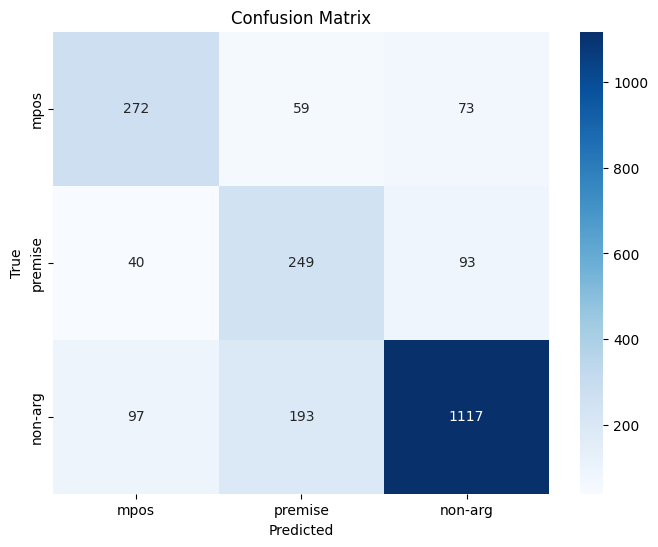

Top 20 Features:
kaum: 0.0021
verbreitern: 0.0021
rheinstraße: 0.0021
danke: 0.0022
dringend: 0.0022
entfernen: 0.0023
geschaffen: 0.0023
kommt: 0.0024
sollten: 0.0025
führt: 0.0026
schaffen: 0.0027
steht: 0.0027
zugeparkt: 0.0028
oft: 0.0031
bessere: 0.0031
wäre: 0.0032
schmal: 0.0034
freigeben: 0.0035
name entfernt: 0.0035
gefährlich: 0.0038


['rf_model.pkl']

In [ ]:
print(f"Best parameters: {grid_search.best_params_}")

# Classification report with warning suppression
print(classification_report(y_test, predictions, zero_division=0))
print(f"Macro F1: {f1_score(y_test, predictions, average='macro', zero_division=0)}")

# Confusion Matrix
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=valid_labels, yticklabels=valid_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# add top 20 features
tfidf = best_model.named_steps['tfidf']
clf = best_model.named_steps['clf']
importances = clf.feature_importances_
indices = importances.argsort()[-20:]
features = tfidf.get_feature_names_out()

print("Top 20 Features:")
for idx in indices:
    print(f"{features[idx]}: {importances[idx]:.4f}")

# Save best model
import joblib
joblib.dump(best_model, 'rf_model.pkl')

## Results
### Results for RF v2.1

**Best parameters:**  
`{'clf__max_depth': None, 'clf__n_estimators': 200, 'tfidf__max_features': 3000}`

| Class        | Precision | Recall | F1-Score | Support |
| ------------ | --------- | ------ | -------- | ------- |
| mpos         | 0.57      | 0.60   | 0.59     | 404     |
| non-arg      | 0.48      | 0.57   | 0.52     | 382     |
| premise      | 0.83      | 0.78   | 0.80     | 1407    |

| Metric       | Value     |
| ------------ | --------- |
| Accuracy     | 0.71      |
| Macro Avg F1 | 0.64      |
| Weighted Avg F1 | 0.72   |

**Macro F1:** 0.6375

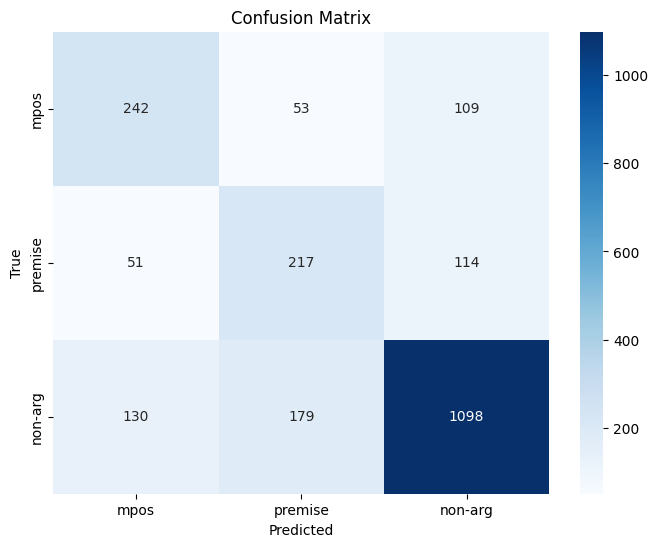

**Top 20 Features:**

| Feature         | Importance |
| --------------- | ---------- |
| fahrradstraße   | 0.0042     |
| autofahrer      | 0.0043     |
| fahren          | 0.0047     |
| oft             | 0.0049     |
| bitte           | 0.0049     |
| fußgänger       | 0.0050     |
| kommt           | 0.0051     |
| bessere         | 0.0055     |
| schmal          | 0.0056     |
| radwege         | 0.0060     |
| gibt            | 0.0063     |
| sollten         | 0.0064     |
| gefährlich      | 0.0067     |
| richtung        | 0.0068     |
| straße          | 0.0087     |
| mehr            | 0.0093     |
| autos           | 0.0097     |
| radweg          | 0.0129     |
| radfahrer       | 0.0133     |
| wäre            | 0.0143     |

### Results for RF v2.2 (XBG)
**Best parameters:**  
`{'clf__learning_rate': 0.3, 'clf__max_depth': 10, 'clf__n_estimators': 200, 'tfidf__max_features': 5000}`

| Class | Precision | Recall | F1-Score | Support |
| ----- | --------- | ------ | -------- | ------- |
| 0     | 0.67      | 0.67   | 0.67     | 404     |
| 1     | 0.50      | 0.65   | 0.56     | 382     |
| 2     | 0.87      | 0.79   | 0.83     | 1407    |

| Metric         | Value  |
| -------------- | ------ |
| Accuracy       | 0.75   |
| Macro Avg F1   | 0.69   |
| Weighted Avg F1| 0.75   |

**Macro F1:** 0.6879


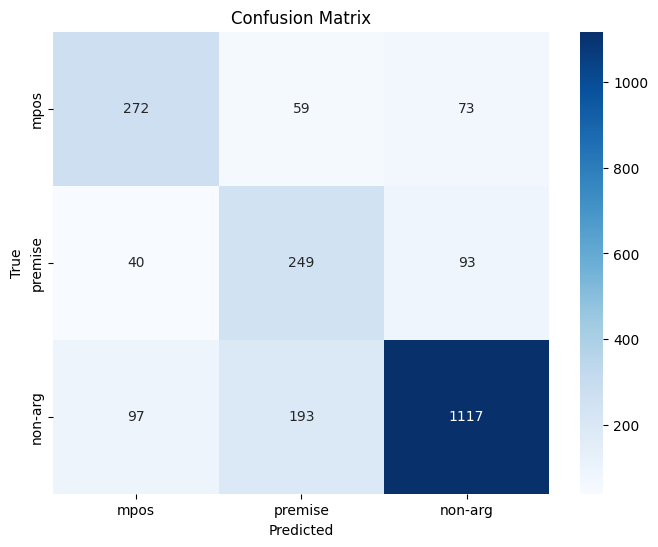


**Top 20 Features:**

| Feature          | Importance |
| ---------------- | ---------- |
| kaum             | 0.0021     |
| verbreitern      | 0.0021     |
| rheinstraße      | 0.0021     |
| danke            | 0.0022     |
| dringend         | 0.0022     |
| entfernen        | 0.0023     |
| geschaffen       | 0.0023     |
| kommt            | 0.0024     |
| sollten          | 0.0025     |
| führt            | 0.0026     |
| schaffen         | 0.0027     |
| steht            | 0.0027     |
| zugeparkt        | 0.0028     |
| oft              | 0.0031     |
| bessere          | 0.0031     |
| wäre             | 0.0032     |
| schmal           | 0.0034     |
| freigeben        | 0.0035     |
| name entfernt    | 0.0035     |
| gefährlich       | 0.0038     |


### Validation with data from Swiss voting booklets
Source: https://www.bk.admin.ch/bk/de/home/dokumentation/abstimmungsbuechlein.html

I have downloaded and isolated pdf for a separate voting topic.


In [ ]:
!pip install PyPDF2
!pip install colorama

import PyPDF2
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

from nltk.tokenize import sent_tokenize
import os
import joblib  # For loading the saved model


import colorama
from colorama import Fore

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 5.7 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
model_path = 'rf_model.pkl'  # make sure that you get the right model: RF or XGB
best_model = joblib.load(model_path)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
known_classes = ['mpos', 'non-arg', 'premise']  # include 'mpos+premise' if not merged
le.fit(known_classes)

# Validation dir
validation_dir = base_dir + file_dir + '/validation/'
print(f"Validation directory: {validation_dir}")

# Function to extract text from a PDF
def extract_text_from_pdf(pdf_path):
    text = ""
    try:
        with open(pdf_path, 'rb') as file:
            reader = PyPDF2.PdfReader(file)
            for page in reader.pages:
                page_text = page.extract_text()
                if page_text:  # Handle cases where extraction fails
                    text += page_text + "\n"
        return text
    except Exception as e:
        print(f"Error extracting {pdf_path}: {e}")
        return ""

# Function to visualize predictions
def visualize_predictions(sentences, predictions):
    label_map = {
        'mpos': '[claim]',
        'premise': '[premise]',
        'non-arg': '[non-arg]',  # Or '' to skip marking non-args
        # 'mpos+premise': '[claim+premise]'  # If not merged
    }
    for sent, pred in zip(sentences, predictions):
        tag = label_map.get(pred, '')
        if tag:
          if tag == '[non-arg]':
            color = Fore.BLACK
          else:
            color = Fore.BLUE

          print(f"{Fore.RED}{tag} {color}{sent}")
        else:
          print(color + sent)  # for unknown

# Process all PDFs in the validation directory
pdf_files = [f for f in os.listdir(validation_dir) if f.lower().endswith('.pdf')]
print(f"Found {len(pdf_files)} PDFs: {pdf_files}")

for pdf_file in pdf_files:
    pdf_path = os.path.join(validation_dir, pdf_file)
    print(f"\nProcessing: {pdf_file}")

    # Extract raw text
    raw_text = extract_text_from_pdf(pdf_path)
    if not raw_text:
        continue

    # Split into sentences (using NLTK; works for German too)
    sentences = sent_tokenize(raw_text, language='german')  # Specify 'german' for better accuracy

    # Preprocess each sentence (using your preprocess_text function)
    preprocessed_sentences = [preprocess_text(sent) for sent in sentences]

    # Predict (model expects list of texts)
    numerical_preds = best_model.predict(preprocessed_sentences)

    # Decode numerical labels back to strings
    predicted_labels = le.inverse_transform(numerical_preds)

    # Visualize
    print("Visualized Output:")
    visualize_predictions(sentences, predicted_labels)
    print("\n" + "="*80 + "\n")

Validation directory: /content/gdrive/My Drive/masterThesis/cimt-argument-mining-dataset-main/validation/
Found 1 PDFs: ['Vorlage_Mieten.pdf']

Processing: Vorlage_Mieten.pdf
Visualized Output:
[non-arg] 38 Dritte Vorlage: Kündigung wegen Eigenbedarfs
Argumente Referendumskomitee
Unter dem Vorwand des Eigenbedarfs wird der Kündigungs -
schutz geschwächt.
[premise] Diese Vorlage ist zusammen mit jener zur 
Untermiete Teil eines grossen Angriffs auf den Mieterschutz.
[claim] Die mächtige Immobilien-Lobby will Mietenden einfacher 
kündigen können, um danach die Mieten noch stärker zu 
erhöhen.
[non-arg] Aber die Folgen einer Wohnungskündigung sind 
schlimm: Ältere Menschen werden aus ihrem Umfeld gerissen, 
Familien verlieren ihr Zuhause.
[claim] Deshalb: Nein zu dieser unge -
rechten Vorlage.
[non-arg] Die Schwächung des Kündigungsschutzes ist ungerecht -
fertigt.
[premise] Eine Kündigung wegen Eigenbedarfs ist schon heute 
möglich.
[premise] Wer eine Wohnung vermietet und diese selbst o